## Q&A System App in LangGraph

This Q&A System App is built for Q&A over a SQL database. The application gives an LLM access to tools for querying and interacting with the data. It follows the recommendation from LangGraph to load the CSV file into a SQL database instead of directly working with a CSV file. Using SQL requires executing model-generated SQL queries. If instead the graph was directly handling the data from CSV, it would require using a library like Pandas and letting the model execute Python code. Since it is easier to tightly scope SQL connection permissions and sanitize SQL queries than it is to sandbox Python environments, [LangGraph's documentation](https://python.langchain.com/docs/tutorials/sql_qa/) recommends interacting with CSV data via SQL. This is the approach followed in this notebook and analyzed a dataset about products on Amazon.

In [17]:
# Setup
%pip install -qU langgraph langchainhub langchain-community groq pandas

Note: you may need to restart the kernel to use updated packages.


In [18]:
# Import libraries
import os
import sys
import yaml
from dotenv import load_dotenv

import tiktoken
import getpass

import pandas as pd

from typing import TypedDict
from typing_extensions import Annotated

from langchain_community.utilities import SQLDatabase
from langchain_community.tools.sql_database.tool import QuerySQLDatabaseTool
from langchain_groq import ChatGroq
from langgraph.graph import START, StateGraph

from langchain import hub

from IPython.display import Image, display

In [19]:
# Load environment variables
# Returns "True" if successful
load_dotenv()

True

In [20]:
# Load config.yaml file
with open("config.yaml", "r") as f:
    config = yaml.safe_load(f)

In [21]:
# Load specifications from config.yaml
llm_config = config["llm"]
encoder_name = config["tiktoken_encoder"]
prompts = config["prompts"]
csv_save = config["csv"]
benchmark_keywords = config["benchmark"]

In [ ]:
# Get API key for GROQ
if not os.environ.get("GROQ_API_KEY"):
  os.environ["GROQ_API_KEY"] = getpass.getpass("Enter API key for Groq: ")

In [23]:
# LLM Setup
llm = ChatGroq(
    model=llm_config["langgraph_agent_model"],
    api_key=os.environ['GROQ_API_KEY'],
    temperature=llm_config["temperature"],
    max_tokens=llm_config["max_tokens"],
    )

In [24]:
enc = tiktoken.get_encoding(encoder_name) 

In [25]:
# Connect to database
db = SQLDatabase.from_uri("sqlite:///amazon_cleaned.db")
print(db.dialect)
print(db.get_usable_table_names())
db.run("SELECT * FROM amazon_cleaned LIMIT 10;")

sqlite
['amazon_cleaned']


'[(\'B0912WJ87V\', \'Reffair AX30 [MAX] Portable Air Purifier for Car, Home & Office | Smart Ionizer Function | H13 Grade True HEPA Filter [Internationally Tested] Aromabuds Fragrance Option - Black\', \'Car&Motorbike\', \'Car&Motorbike|CarAccessories|InteriorAccessories|AirPurifiers&Ionizers\', \'₹2,339\', \'₹4,000\', \'42%\', 3.8, \'1,118\', \'[NEW LAUNCH - INNOVATIVE DESIGN] EFFICIENT PURIFICATION TECHNOLOGY - Reffair AX30 has the tapered design with an H13 HEPA filter and Smart Negative Ions feature which makes this device perform better and it comes with an effective CADR of 16.2 m³/h.\\xa0AX30 is Re-designed\\xa0in the year 2021,...\', \'AG6W5HESRSDLBX3NCYOOUGFOWERA,AED4U5CF37HVSYPMD6KUP3YPH36A,AGUHDV5GZZQ53BGLNLV654IPDASQ,AEDMXTLZRXBSPPDRYIN6PAGXFXCA,AEVBIVJJCIRYJRR7G47DFT6SFBAA,AF65HJXCS64PXG5GMEBZOLVCZSPQ,AE5CGWMRDJN6NMXZ5XH74X2GIRNQ,AEDVMC3DUI5UUVQ43C4XLLZJGWUA\', \'Arivazhagan,Ajit,swanand pandit,Venkatesh S.,Shubham Sharma,arun chaturvedi,Amazon Customer,sanket\', \'R3TOOFP

Using SQL to interact with CSV data is the recommended approach because it is easier to limit permissions and sanitize queries than with arbitrary Python. I already have loaded the CSV file in a SQL database. After that it is possible to use all of the chain and agent-creating techniques outlined in the SQL tutorial provided by LangGraph. In the below I use SQLite.

In [26]:
# Define the LangGraph state of the application
class State(TypedDict):
    question: str
    query: str
    result: str
    answer: str

In [27]:
# Pull a prompt from the Prompt Hub to instruct the model.
query_prompt_template = hub.pull("langchain-ai/sql-query-system-prompt")

assert len(query_prompt_template.messages) == 1
query_prompt_template.messages[0].pretty_print()

c:\Users\tsvet\anaconda3\envs\langgraph\Lib\site-packages\langsmith\client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


================================ System Message ================================

Given an input question, create a syntactically correct {dialect} query to run to help find the answer. Unless the user specifies in his question a specific number of examples they wish to obtain, always limit your query to at most {top_k} results. You can order the results by a relevant column to return the most interesting examples in the database.

Never query for all the columns from a specific table, only ask for a the few relevant columns given the question.

Pay attention to use only the column names that you can see in the schema description. Be careful to not query for columns that do not exist. Also, pay attention to which column is in which table.

Only use the following tables:
{table_info}

Question: {input}


The prompt includes several parameters we will need to populate, such as the SQL dialect and table schemas. LangChain's SQLDatabase object includes methods to help with this. Our write_query step will just populate these parameters and prompt a model to generate the SQL query:

In [28]:
class QueryOutput(TypedDict):
    """Generated SQL query."""

    query: Annotated[str, ..., "Syntactically valid SQL query."]


def write_query(state: State):
    """Generate SQL query to fetch information."""
    prompt = query_prompt_template.invoke(
        {
            "dialect": db.dialect,
            "top_k": 10,
            "table_info": db.get_table_info(),
            "input": state["question"],
        }
    )
    structured_llm = llm.with_structured_output(QueryOutput)
    result = structured_llm.invoke(prompt)
    return {"query": result["query"]}

In [ ]:
# Write a sample question
write_query({"question": "How many products are there?"})

{'query': 'SELECT COUNT(product_id) FROM amazon_cleaned LIMIT 10'}

In [ ]:
# Create a function for executing a SQL Query
def execute_query(state: State):
    """Execute SQL query."""
    execute_query_tool = QuerySQLDatabaseTool(db=db)
    return {"result": execute_query_tool.invoke(state["query"])}

In [ ]:
# Test executing a sample SQL query
execute_query({"query": 'SELECT COUNT(product_id) FROM amazon_cleaned'})

{'result': '[(1351,)]'}

In [32]:
# Generate an answer to the question given the information pulled from the database
def generate_answer(state: State):
    """Answer question using retrieved information as context."""
    prompt = (
        "Given the following user question, corresponding SQL query, "
        "and SQL result, answer the user question.\n\n"
        f'Question: {state["question"]}\n'
        f'SQL Query: {state["query"]}\n'
        f'SQL Result: {state["result"]}'
    )
    response = llm.invoke(prompt)
    return {"answer": response.content}

In [33]:
# Orchestrate with LangGraph
graph_builder = StateGraph(State).add_sequence(
    [write_query, execute_query, generate_answer]
)
graph_builder.add_edge(START, "write_query")
graph = graph_builder.compile()

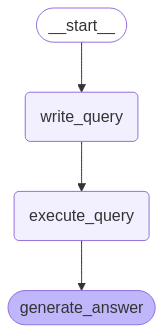

In [35]:
# Display the image representing the graph
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
# Test the application
for step in graph.stream(
    {"question": "How many products are in the database?"}, stream_mode="updates"
):
    print(step)

{'write_query': {'query': 'SELECT COUNT(product_id) FROM amazon_cleaned'}}
{'execute_query': {'result': '[(1351,)]'}}
{'generate_answer': {'answer': 'There are 1351 products.'}}
